# What to do with 10,000 simultaneous neurons?  

# Section 1. Loading and preparing. 

### 1.0 Load in the Python libraries

In [1]:
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from matplotlib import pyplot as plt # plotting functions. second most important library.
%matplotlib inline 
# %matplotlib notebook # if you need to zoom into a figure, this is the "interactive" mode of IPython
# you cannot go back and forth between interactive and inline modes (restart nootebook instead)

# scipy is an "expansion" of numpy with more specialized functions
from scipy import stats # here we import a sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function for temporal smoothing

# sklearn is the "machine learning" library. Has lots of good stuff, except deep learning. 
from sklearn.decomposition import PCA 

In [20]:
gaussian_filter

<function scipy.ndimage.filters.gaussian_filter(input, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)>

In [21]:
gaussian_filter?

<module 'matplotlib.pyplot' from '/home/neuraldata/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

### 1.1 Load the metadata

In [2]:
# this cell loads Suite2p configuration file "ops", and stimulus information (mov, iframe)
mname, datexp, blk = 'TX39', '2019_05_31', '1' # this assignment works! 

root      = '/home/neuraldata/data/meso'
mov       = np.load(os.path.join(root, 'mov.npy')) # mov contains the sparse noise frames
iframe    = np.load(os.path.join(root, 'iframe.npy')) # iframe[n] is the microscope frame for the image frame n

# ops is a "pickled" dictionary, not just an array
ops = np.load(os.path.join(root, 'suite2p', 'combined', 'ops.npy'), allow_pickle=True).item() 

In [29]:
# dictionaries have "keys"
ops.keys()

dict_keys(['look_one_level_down', 'fast_disk', 'delete_bin', 'mesoscan', 'h5py', 'h5py_key', 'save_path0', 'subfolders', 'nplanes', 'nchannels', 'functional_chan', 'diameter', 'tau', 'fs', 'force_sktiff', 'save_mat', 'combined', 'num_workers', 'num_workers_roi', 'do_bidiphase', 'bidiphase', 'do_registration', 'keep_movie_raw', 'nimg_init', 'batch_size', 'maxregshift', 'align_by_chan', 'reg_tif', 'reg_tif_chan2', 'subpixel', 'do_phasecorr', 'smooth_sigma', 'th_badframes', 'pad_fft', 'nonrigid', 'block_size', 'snr_thresh', 'maxregshiftNR', '1Preg', 'spatial_hp', 'pre_smooth', 'spatial_taper', 'connected', 'navg_frames_svd', 'nsvd_for_roi', 'max_iterations', 'smooth_masks', 'threshold_scaling', 'max_overlap', 'ratio_neuropil', 'ratio_neuropil_to_cell', 'tile_factor', 'inner_neuropil_radius', 'outer_neuropil_radius', 'min_neuropil_pixels', 'high_pass', 'chan2_thres', 'baseline', 'win_baseline', 'sig_baseline', 'prctile_baseline', 'neucoeff', 'allow_overlap', 'xrange', 'yrange', 'roidetect'

<IPython.core.display.Javascript object>


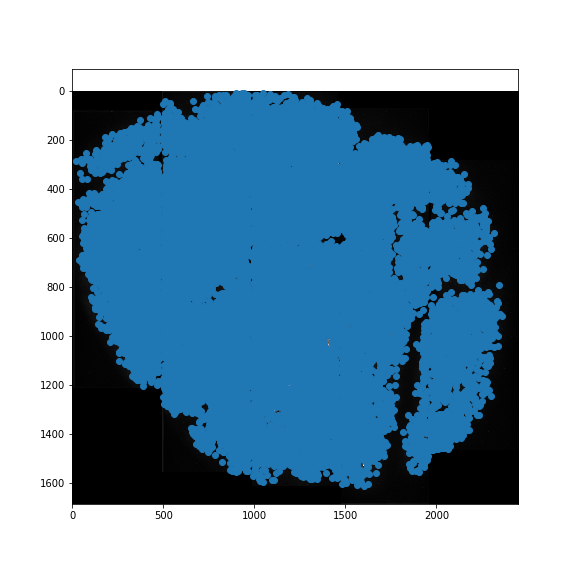

In [57]:
%matplotlib notebook 

plt.figure(figsize=(8,8))
plt.imshow(ops['max_proj'], vmax=5000, cmap = 'gray', aspect='auto')

### 1.2 Load the neural data

In [55]:
spks = np.load(os.path.join(root, 'suite2p', 'combined', 'spks.npy'))
stat = np.load(os.path.join(root, 'suite2p', 'combined', 'stat.npy'), allow_pickle=True)

ypos = [stat[k]['med'][0] for k in range(len(stat))]
xpos = [stat[k]['med'][1] for k in range(len(stat))]
ypos, xpos = np.array(ypos), np.array(xpos)

ypos, xpos = ypos/.5, xpos/.75 # this recording had 0.5 pixels/um in Y and 0.75 pixels/um in X

print('total neurons %d'%len(stat))
print('recorded from an area of %2.2f um by %2.2f um'%(np.ptp(ypos), np.ptp(xpos)))

total neurons 18795
recorded from an area of 3212.00 um by 3122.67 um


In [58]:
# because we are in notebook mode, this will plot to the last interactive plot
plt.scatter(xpos*.75, ypos*.5) 

In [59]:
# switch back to inline plots so we can make them bigger
%matplotlib inline

### 1.3 By the end of this section you should have spks, Timeline, xpos, ypos in your workspace. 
Try to explore the contents of these variables, for example:

In [60]:
print('total neurons %d'%len(stat))

total neurons 18795


In [61]:
print(stat[0].keys())

dict_keys(['ypix', 'lam', 'xpix', 'mrs', 'mrs0', 'compact', 'med', 'npix', 'footprint', 'npix_norm', 'overlap', 'ipix', 'radius', 'aspect_ratio', 'skew', 'std', 'iplane'])


In [62]:
print(np.min(ypos), np.max(ypos), np.min(xpos), np.max(xpos))

12.0 3224.0 26.666666666666668 3149.3333333333335


In [6]:
# use this empty cell to determine how many timepoints are in the dataset, and how many images have been presented 

# Section 2. Plotting and visualizing the data

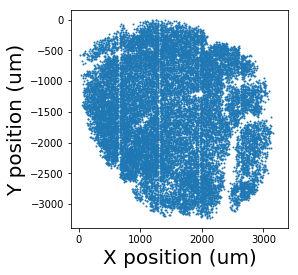

In [87]:
# POSITIONS OF ALL NEURONS
plt.scatter(xpos, -ypos, s = 1) # note we have to invert the Ypos
plt.xlabel('X position (um)', fontsize=20) # this is how you make axis labels
plt.ylabel('Y position (um)', fontsize=20) 
plt.axis('square') # make both axes the same size
plt.show() # when you are done

Text(0.5, 1.0, 'example frame')

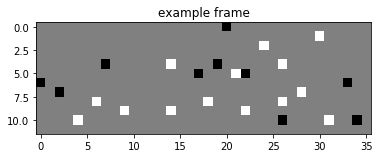

In [84]:
# STIMULUS FRAME
plt.imshow(mov[:,:,100], cmap='gray')
plt.title('example frame') # without plt show, the result of the last command is displayed

In [73]:
dt = 1 # time offset between stimulus and neural activity
ivalid = iframe+dt<spks.shape[-1] # remove timepoints that fall after the neural recording ended
iframe = iframe[ivalid] 
mov = mov[:, :, ivalid]
S = spks[:, iframe+dt]

S = stats.zscore(S, axis=1) # z-score the neural activity before doing anything. axis specifies the dimension. 

Text(0.5, 0, 'time points')

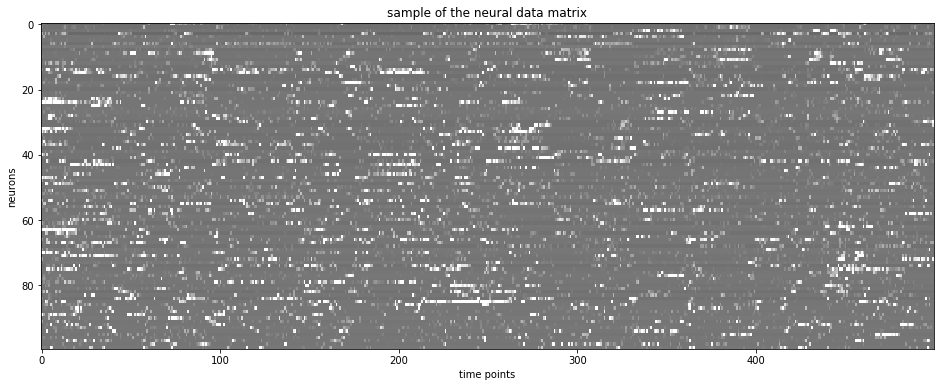

In [107]:
plt.figure(figsize=(16,6))
# display the first 100 neurons and the first 500 timepoints
plt.imshow(S[:100, :500], vmax = 3, vmin = -3, aspect='auto', cmap = 'gray')
plt.title('sample of the neural data matrix')
plt.ylabel('neurons') 
plt.xlabel('time points')

# Section 3. Receptive fields  (ON - OFF)

### 3.1 First, compute ordinary ON - OFF receptive fields

In [90]:
nn = 8867
NN, NT = S.shape 
S0 = S[nn, :]

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints. -1 means the dimension is automatically inferred. 
X = X-0.5 # subtract the gray level
X = np.abs(X) # does not matter if a pixel is black (-0.5) or white (0.5)
X = stats.zscore(X, axis=1)/NT**.5  # z-score each pixel separately. Normalize to unit norm. 
npix = X.shape[0]

B0 = X @ S0 # stimulus triggered receptive field for one neuron
B0 = np.reshape(B0, [mov.shape[0], mov.shape[1]])

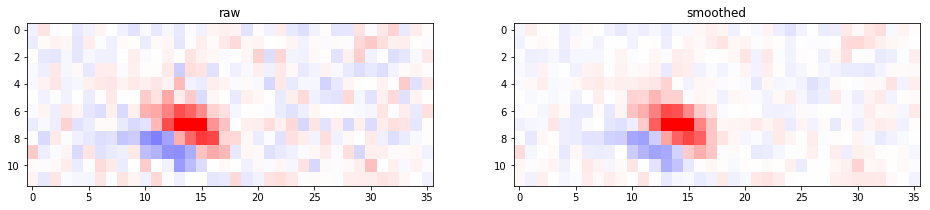

In [91]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.imshow(B0, aspect='auto', vmin=-12, vmax=12, cmap = 'bwr') # plot the receptive field for each neuron
plt.title('raw')

plt.subplot(1,2,2)
B1 = gaussian_filter(B0, [.5, .5]) # smooth each receptive field a little
plt.imshow(B1, aspect='auto', vmin=-12, vmax=12, cmap = 'bwr') # plot the receptive field for each neuron
plt.title('smoothed')
plt.show()

### 3.2 Receptive fields for all neurons

In [92]:
NN, NT = S.shape 

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the gray level
X = stats.zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.0 # regularizer for ridge regression
B0 = X @ S.T # get the receptive fields for each neuron        
B0 = np.reshape(B0, [mov.shape[0], mov.shape[1], NN])
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

B00 = B0

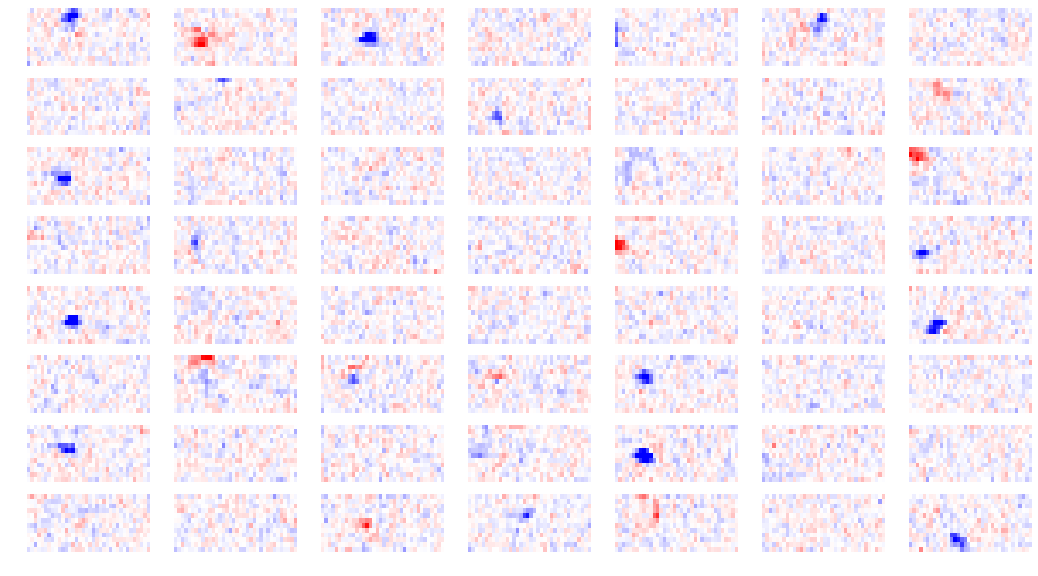

In [93]:
plt.figure(figsize=(18, 10))
np.random.seed(1) # set the seed for the random number generator, so that our random samples are reproducible
rperm = np.random.permutation(NN) # choose a random set of neurons

#isort = np.argsort(np.max(B0, axis=(0,1))- np.min(B0, axis=(0,1)))
#isort = np.argsort(-np.min(B0, axis=(0,1)))
#isort = np.argsort(np.max(B0, axis=(0,1)))

for j in range(8*7):
    plt.subplot(8,7,j+1)
    plt.imshow(B00[:,:,rperm[j]], aspect='auto', vmin=-6, vmax=6, cmap = 'bwr') # plot the receptive field for each neuron
    plt.axis('off')
    
plt.show()

# Section 4. Receptive fields (ON + OFF)

### 4.1 Do the neurons care about contrast SIGN ?

In [94]:
X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # does not matter if a pixel is black (0) or white (1)
X = np.abs(X) # response is the same for ON and OFF squares

X = stats.zscore(X, axis=1)/NT**.5  # z-score each pixel separately
B0 = X @ S.T # get the receptive fields for each neuron

B0 = np.reshape(B0, [mov.shape[0], mov.shape[1], NN])
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

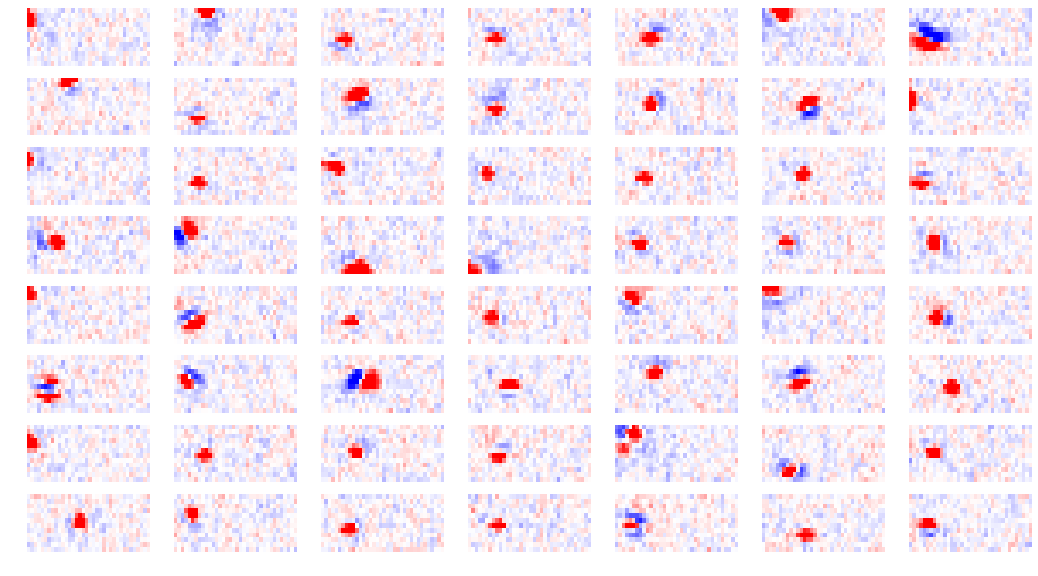

In [99]:
plt.figure(figsize=(18, 10))
#isort = rperm
isort = np.argsort(np.max(B0, axis=(0,1))- np.min(B0, axis=(0,1)))[::-1]
#isort = np.argsort(-np.min(B0, axis=(0,1)))[::-1]
#isort = np.argsort(np.max(B0, axis=(0,1)))[::-1]

for j in range(7*8):
    plt.subplot(8,7,j+1)
    plt.imshow(B0[:,:,isort[j]], aspect='auto', vmin=-6, vmax=6, cmap = 'bwr') # plot the receptive field for each neuron
    plt.axis('off')
    
plt.show()

### 4.2 Let's average the ON+OFF receptive fields over groups of neurons

In [100]:
sig = 50 # average neurons within this distance
B = np.zeros(B0.shape)
for j in range(NN):
    ds = (ypos[j] - ypos)**2 + (xpos[j] - xpos)**2
    ix = ds**.5<sig
    B[:,:,j] = np.mean(B0[:,:,ix], axis=-1) # average receptive fields within sig
    
Amax = np.max(np.max(B, axis=0), axis=0) # maximum response to preferred stimulus

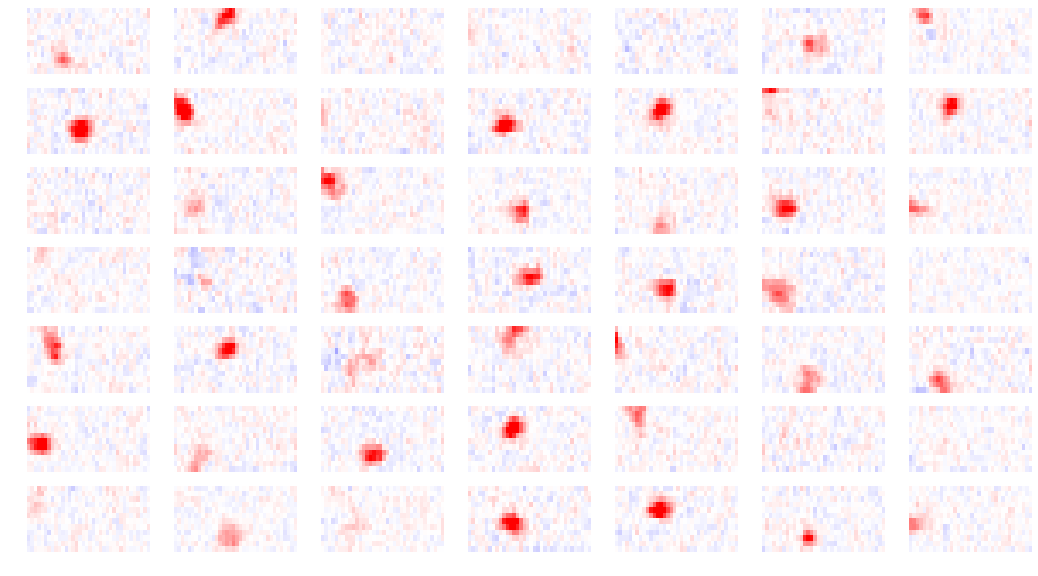

In [101]:
plt.figure(figsize=(18, 10))
np.random.seed(101) # set the seed for the random number generator, so that our random samples are reproducible
rperm = np.random.permutation(NN) # choose a random set of neurons

for j in range(7*7):
    plt.subplot(7,7,j+1)
    plt.imshow(B[:,:,rperm[j]], aspect='auto', vmin=-3, vmax=3, cmap = 'bwr') # plot the receptive field for each neuron
    plt.axis('off')
    
plt.show()

### 4.3 Finally, let's display the retinotopy over the recording area

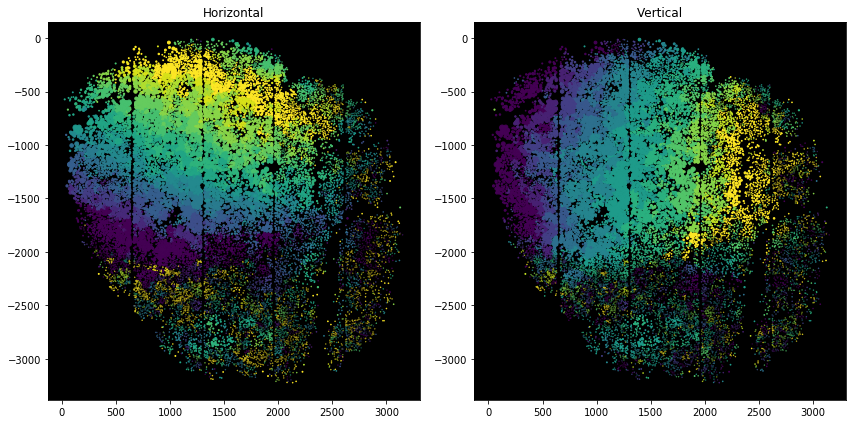

In [104]:
imax = np.argmax(np.reshape(B, [-1,NN]), axis=0) # find the pixel corresponding to the max response for each cell
ly, lx, nstim = mov.shape

# xmax, ymax = np.unravel(imax, (ly, lx)) # unravel an index for a (1,ly*lx) array, to two indices for an (ly, lx) array
xmax = np.minimum(17, imax%lx)
ymax = (imax/lx).astype('int')

plt.figure(figsize=(12,6))

plt.subplot(1,2,1, facecolor=[0, 0, 0])
plt.scatter(xpos, -ypos, s = .25 * (Amax)**2, c = xmax, cmap='viridis')
plt.title('Horizontal')

plt.subplot(1,2,2, facecolor=[0, 0, 0])
plt.scatter(xpos, -ypos, s = .25 * (Amax)**2, c = ymax, cmap='viridis')
plt.title('Vertical')

plt.tight_layout()

plt.show()